INITIALIZATION

In [154]:
%pip install pandas matplotlib numpy wordcloud

   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.4 kB ? eta -:--:--
   --- ----------------------------------- 30.7/301.4 kB 262.6 kB/s eta 0:00:02
   ----- --------------------------------- 41.0/301.4 kB 245.8 kB/s eta 0:00:02
   ------- ------------------------------- 61.4/301.4 kB 328.2 kB/s eta 0:00:01
   ----------------------------- ---------- 225.3/301.4 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from wordcloud import WordCloud

LOADING CLEANED DATA

In [67]:
commits_df = pd.read_csv('data_cleaned/commits.csv', parse_dates=['date'])
contributors_df = pd.read_csv('data_cleaned/contributors.csv')
issues_df = pd.read_csv('data_cleaned/issues.csv', parse_dates=['created_at', 'closed_at'])
pull_requests_df = pd.read_csv('data_cleaned/pull_requests.csv', parse_dates=['created_at', 'merged_at', 'closed_at'])
languages_df = pd.read_csv('data_cleaned/languages.csv')
files_df = pd.read_csv('data_cleaned/files.csv')

ANALYSIS OF COMMITS

In [6]:
# Chung
print(f'Số commits trong năm 2023: {commits_df.shape[0]}')
print(f'Số commits trung bình trong ngày: {commits_df.shape[0] / 365:.2f}')

Số commits trong năm 2023: 1349
Số commits trung bình trong ngày: 3.70


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12248\2516810392.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  commits_per_day = commits_df['date'].dt.to_period('D').value_counts().sort_index()


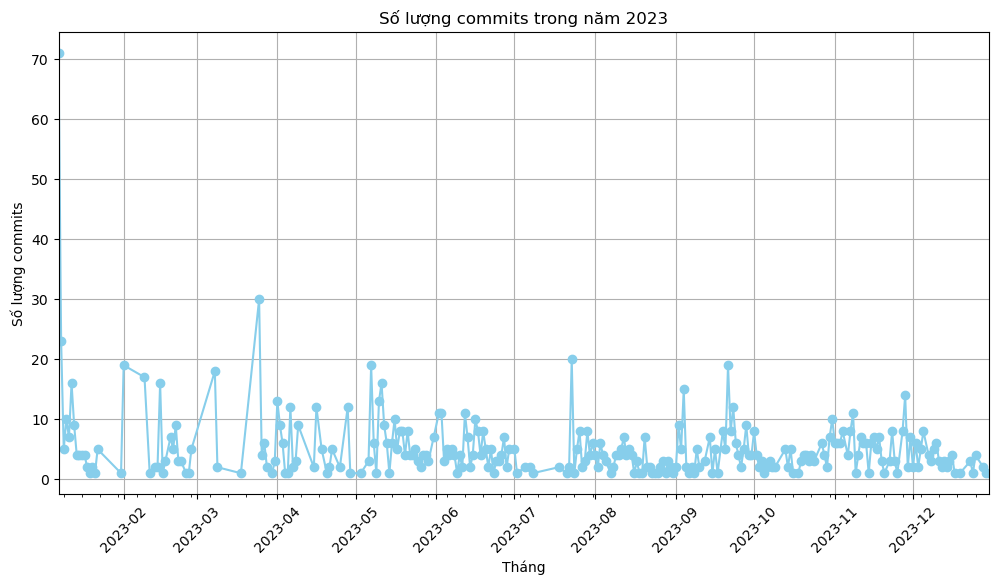

In [7]:
# Phân tích số commits theo thời gian

# Tính số commits theo ngày
commits_per_day = commits_df['date'].dt.to_period('D').value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 6))
commits_per_day.plot(kind='line', color='skyblue', marker='o', ax=ax)

plt.title('Số lượng commits trong năm 2023')
plt.xlabel('Tháng')
plt.ylabel('Số lượng commits')

# Chỉnh cột x theo tháng
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Vẽ biểu đồ đường
plt.grid(True)
plt.show()

In [9]:
# Tính số commits theo contributors
commits_per_contributor = (commits_df['author'].value_counts()).sort_values(ascending=False)

# Chọn 10 người cách đều trong danh sách
indices = np.linspace(0, len(commits_per_contributor) - 1, 10).astype(int)
selected_contributors = commits_per_contributor.iloc[indices]

# Vẽ biểu đồ
selected_contributors.plot(kind='bar', figsize=(12, 6), color='skyblue', log=True)
plt.title('Số lượng commits của 10 contributors (chia đều từ cao đến thấp, log scale)')
plt.xlabel('Contributor')
plt.ylabel('Số lượng commits (log scale)')
plt.xticks(rotation=45)
plt.show()


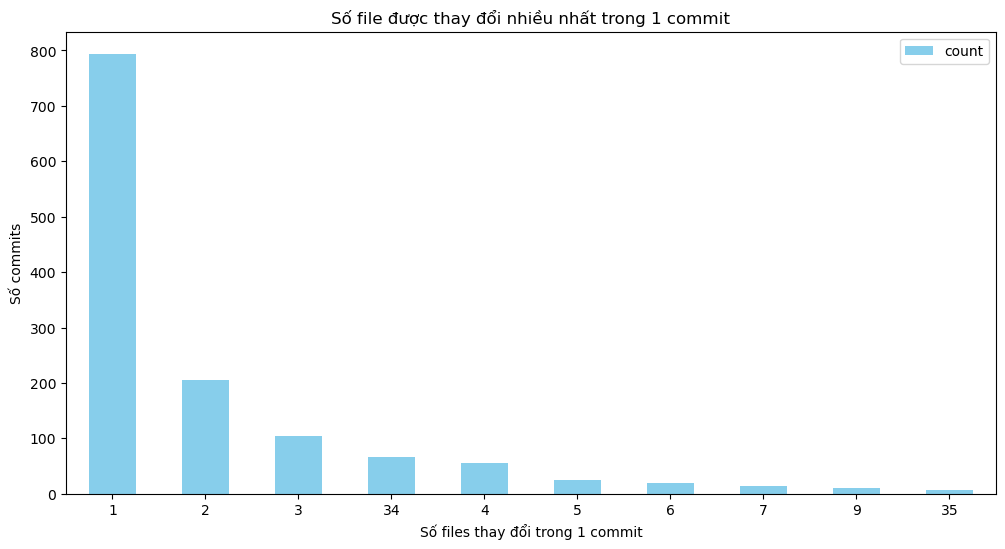

In [10]:
# Phân tích commits theo số files thay đổi

# Tính số commits theo số files thay đổi
files_series = commits_df.explode('files_changed')['files_changed']

# Create a DataFrame with counts of each file
file_counts = files_series.value_counts().reset_index()
file_counts.columns = ['file', 'count']

# Plot the most changed files
file_counts.iloc[:10].plot(kind='bar', x='file', y='count', figsize=(12, 6), color='skyblue')
plt.title('Số file được thay đổi nhiều nhất trong 1 commit')
plt.xlabel('Số files thay đổi trong 1 commit')
plt.ylabel('Số commits')
plt.xticks(rotation = 0)
plt.show()

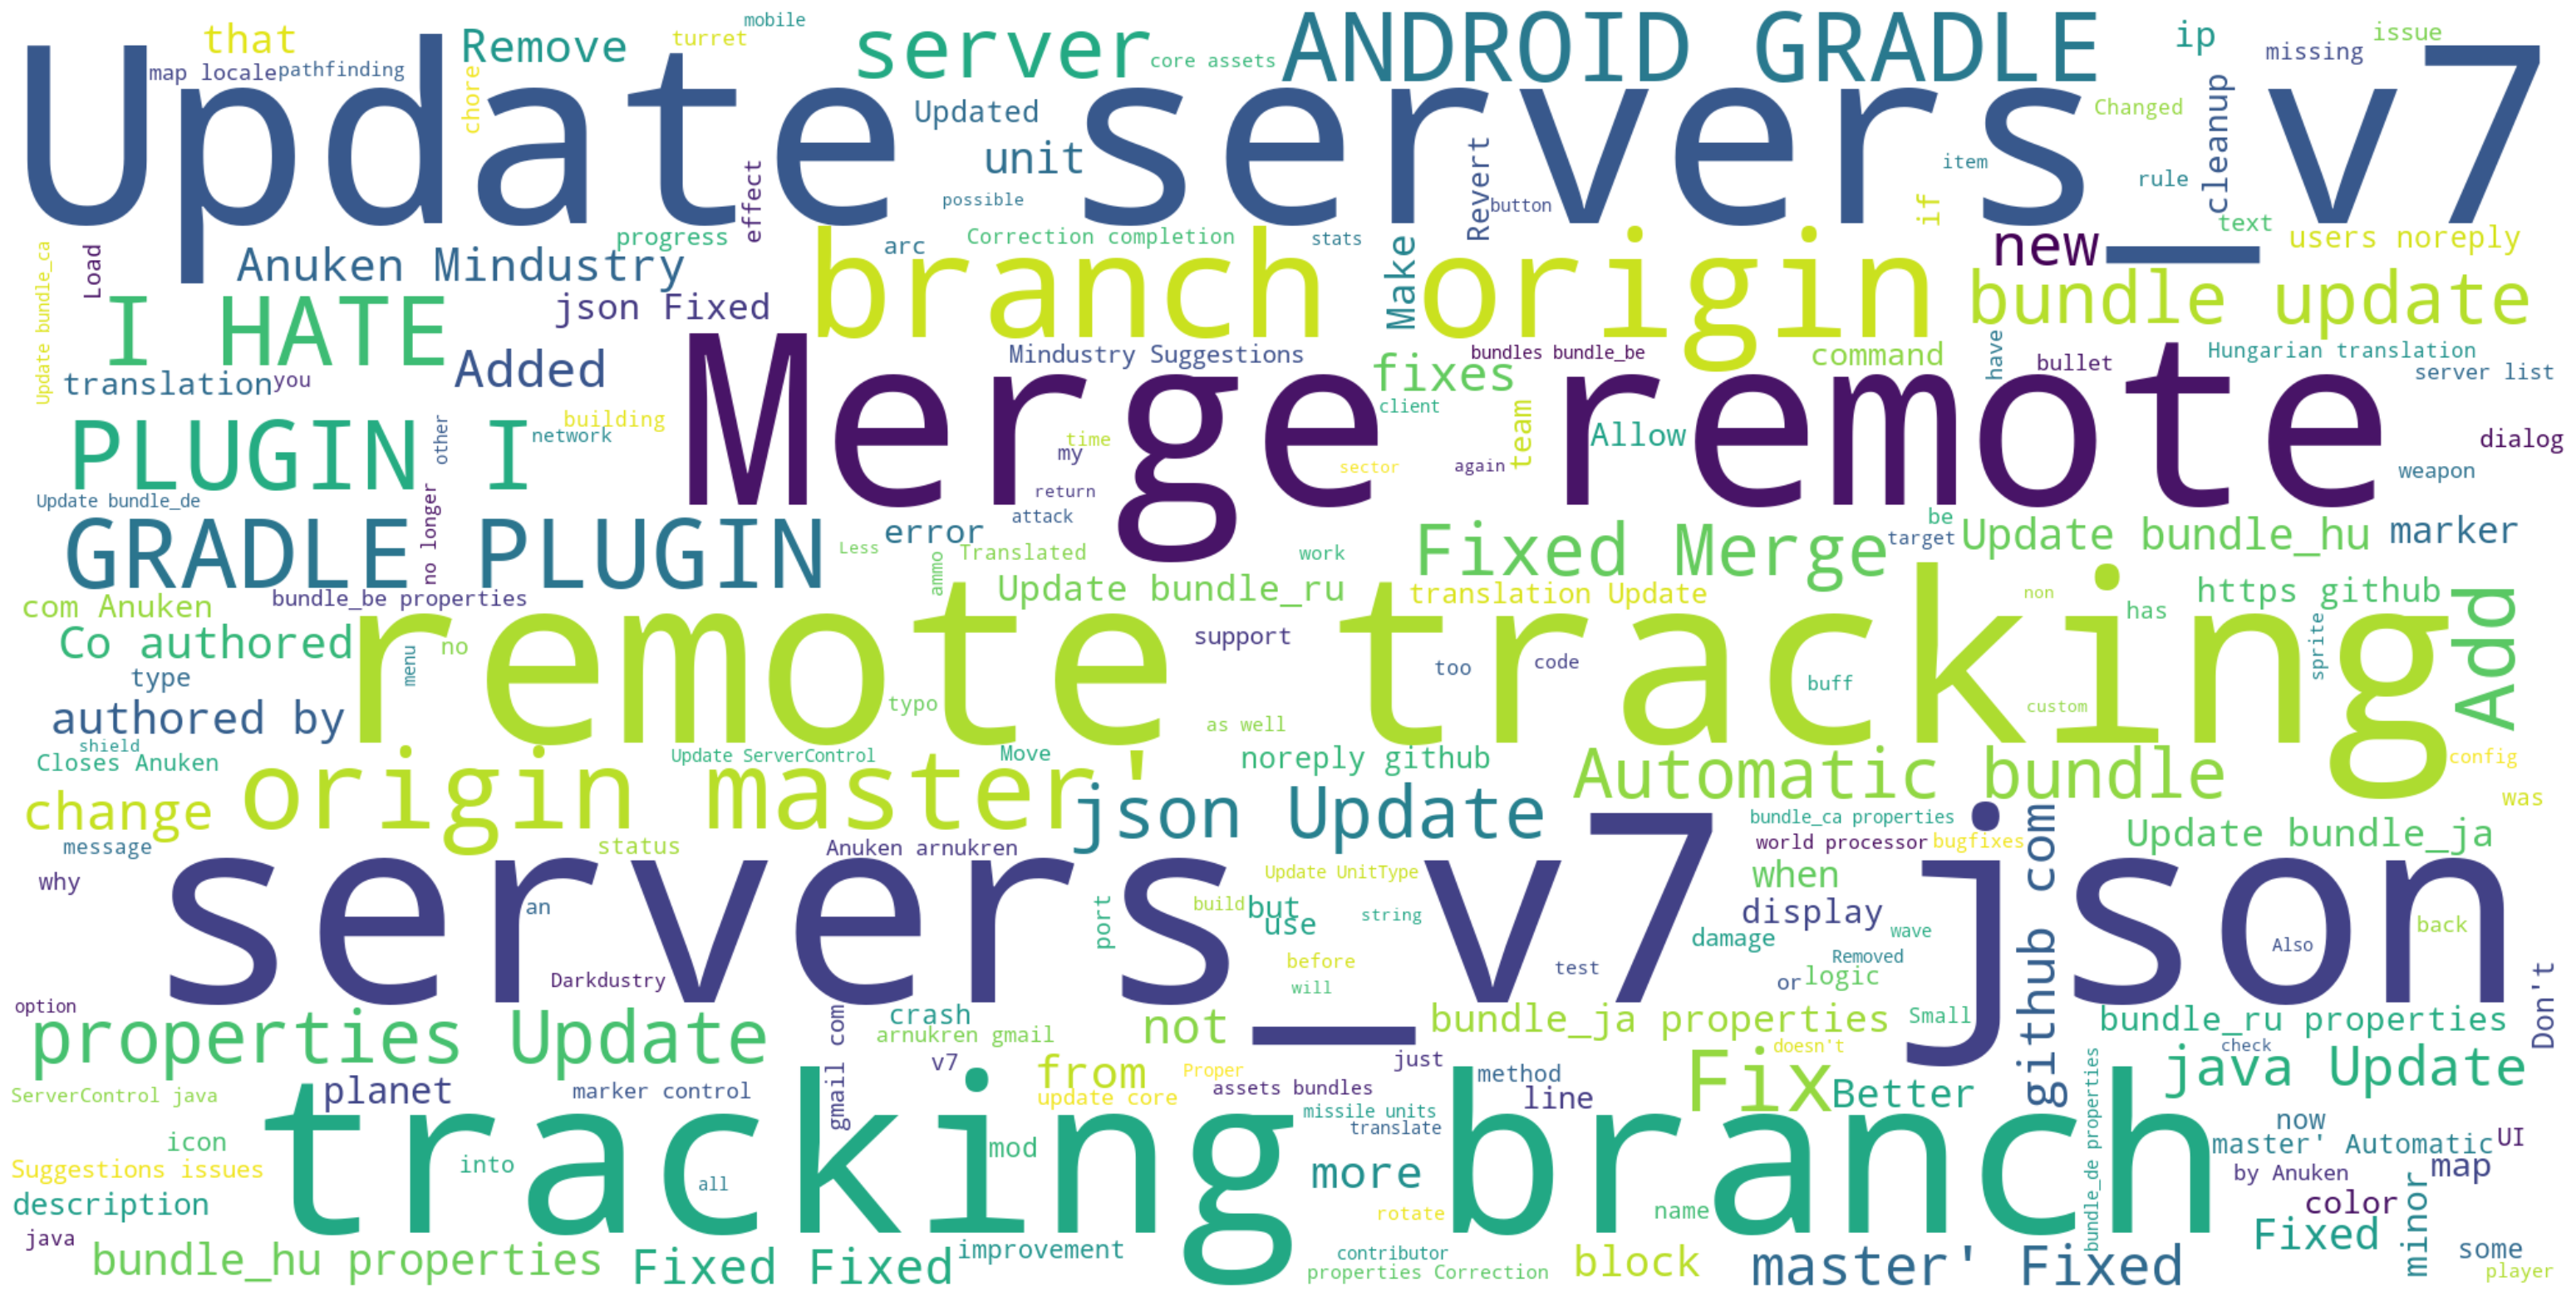

In [11]:
# Phân tích các từ trong commit messages

all_messages = ' '.join(commits_df['message'])
wordcloud = WordCloud(width=2000, height=1000, background_color='white', colormap='viridis', 
                      stopwords=set(['the', 'and', 'to', 'of', 'in', 'a', 'for', 'on', 'with', 'is', 'this', 'it'])).generate(all_messages)

# Vẽ ảnh
plt.figure(figsize=(40, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

ANALYSIS OF CONTRIBUTORS

In [31]:
# Chung
total_contributors = contributors_df.shape[0]
print(f'Tổng số contributors: {total_contributors}')

# Đóng góp nhiều nhất
top_contributor = contributors_df.loc[contributors_df['commits'].idxmax()]
top_contributor_name = top_contributor['login']
top_contributor_commits = top_contributor['commits']
top_contributor_percent = top_contributor['percent_contribution']

print(f'Người đóng góp nhiều nhất: {top_contributor_name}. Đã đóng góp {top_contributor_commits} commits, chiếm {top_contributor_percent:.2f}% trong tổng số commits.')


Tổng số contributors: 381
Người đóng góp nhiều nhất: Anuken. Đã đóng góp 12032 commits, chiếm 70.44% trong tổng số commits.


In [54]:
# Tính khoảng thời gian hoạt động của mỗi contributor
activity_periods = commits_df.groupby('author')['date'].agg(['min', 'max'])
activity_periods['activity_duration'] = activity_periods['max'] - activity_periods['min']
print(f'Thời gian hoạt động trung bình: {(activity_periods['activity_duration'].dt.total_seconds() / 3600).mean():.2f} giờ')

# Người hoạt động đều đặn nhất (nhiều ngày hoạt động nhất)
most_regular_contributor = activity_periods['activity_duration'].idxmax()
most_regular_duration = activity_periods['activity_duration'].max()

print(f'Người hoạt động đều đặn nhất: {most_regular_contributor}')
print(f'Thời gian hoạt động: {most_regular_duration}')

# Người có thời gian đóng góp dài nhất
longest_active_contributor = activity_periods['max'].idxmax()
longest_active_duration = activity_periods.loc[longest_active_contributor, 'activity_duration']

print(f'Người có thời gian đóng góp dài nhất: {longest_active_contributor}')
print(f'Thời gian hoạt động: {longest_active_duration}')


Thời gian hoạt động trung bình: 1816.14 giờ
Người hoạt động đều đặn nhất: Anuken
Thời gian hoạt động: 356 days 09:50:44
Người có thời gian đóng góp dài nhất: Anuken
Thời gian hoạt động: 356 days 09:50:44


In [55]:
# Phân tích contributors theo đóng góp

# Lấy top 10 contributors
top_contributors = contributors_df.nlargest(10, 'commits')

# Tính phần còn lại của các contributors
other_contribution = 100 - top_contributors['percent_contribution'].sum()

# Thêm "Other" vào dữ liệu top contributors
other_row = pd.DataFrame({'login': ['Others (< 1% contribution each)'], 'percent_contribution': [other_contribution]})
top_contributors = pd.concat([top_contributors, other_row], ignore_index=True)

# Vẽ biểu đồ quạt
plt.figure(figsize=(10, 8))
plt.pie(top_contributors['percent_contribution'], labels=top_contributors['login'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Phần trăm đóng góp của các contributors')
plt.show()

In [44]:
# Phân tích contributors theo địa điểm

# Nhóm các contributors có cùng địa điểm
location_counts = contributors_df['location'].value_counts().reset_index()
location_counts.columns = ['location', 'contributors_count']

# Hiển thị bảng
location_counts.iloc[:20]

location  contributors_count
0                 unknown                 232
1                 germany                   6
2                  poland                   4
3                 ukraine                   3
4                  russia                   3
5          czech republic                   3
6                    mars                   3
7                  россия                   2
8                  vienna                   2
9                   china                   2
10              australia                   2
11          united states                   2
12              venezuela                   2
13                  earth                   2
14                  italy                   2
15                 taiwan                   2
16       right behind you                   2
17                  japan                   2
18  whitinsville, ma, usa                   1
19              milky way                   1

ANALYSIS OF ISSUES

In [35]:
# Tổng số issues mở và đóng
total_issues = issues_df.shape[0]
closed_issues = issues_df[issues_df['state'] == 'closed'].shape[0]
print(f'Tổng số issues: {total_issues}')
print(f'Tổng số issues đã đóng: {closed_issues}')


Tổng số issues: 4331
Tổng số issues đã đóng: 4330


In [59]:
# Thời gian trung bình để giải quyết một issue
closed_issues_df = issues_df[issues_df['closed_at'].notna()]
issues_df['resolution_time'] = (issues_df['closed_at'] - issues_df['created_at']).dt.total_seconds() / 3600
average_resolution_time = issues_df['resolution_time'].mean()
print(f'Thời gian trung bình để giải quyết một issue: {average_resolution_time:.2f} giờ')

Thời gian trung bình để giải quyết một issue: 67.76 giờ


In [37]:
# Phân tích issues theo nhãn

# Tạo bảng các nhãn
labels_series = issues_df.explode('labels')['labels']
label_counts = labels_series.value_counts().reset_index()
label_counts.columns = ['label', 'count']

label_counts


label  count
0             ['bug']   3134
1       ['unlabeled']   1170
2  ['bug', 'wontfix']      9
3      ['a disgrace']      8
4     ['help wanted']      8
5           ['draft']      2

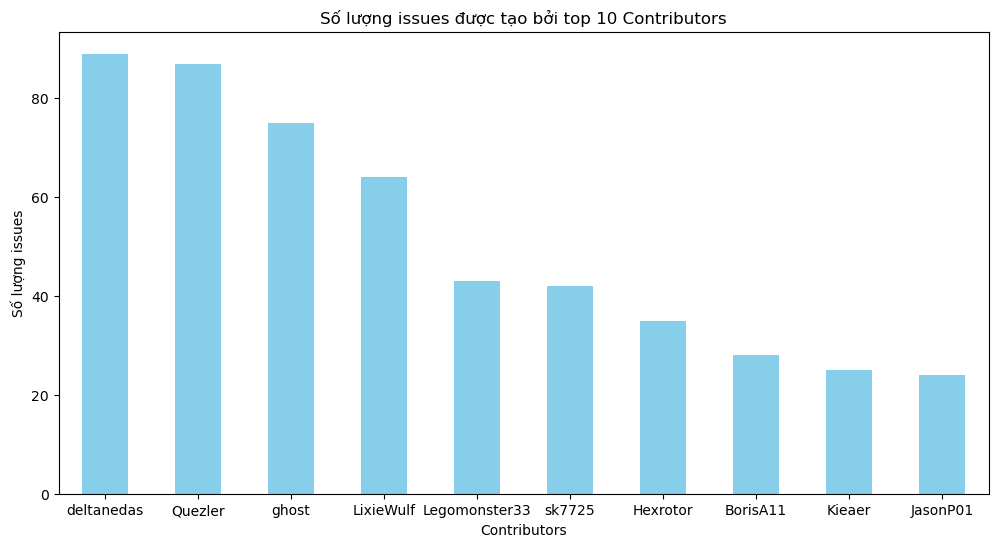

In [38]:
# Phân tích issues theo contributors
issues_per_contributor = issues_df['contributor'].value_counts()

# Chọn 10 contributors đã mở số issues nhiều nhất
top_10_contributors = issues_per_contributor.head(10)

# Vẽ biểu đồ cột
top_10_contributors.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Số lượng issues được tạo bởi top 10 Contributors')
plt.xlabel('Contributors')
plt.ylabel('Số lượng issues')
plt.xticks(rotation= 0)
plt.show()

ANALSIS OF PULL REQUESTS

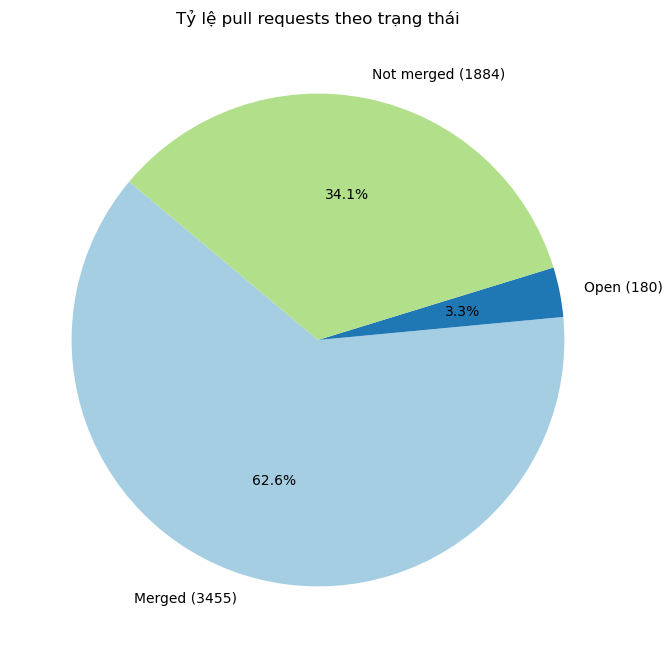

In [39]:
# Tổng số pull requests tạo ra và được merge
total_pull_requests = pull_requests_df.shape[0]
merged_pull_requests = pull_requests_df[pull_requests_df['merged_at'].notna()].shape[0]
open_pull_requests = pull_requests_df[pull_requests_df['state'] == 'open'].shape[0]
unmerged_pull_requests = total_pull_requests - open_pull_requests - merged_pull_requests

pull_requests_status_data = pd.DataFrame({
    'status': ['Merged', 'Open', 'Not merged'],
    'count': [merged_pull_requests, open_pull_requests, unmerged_pull_requests]
})

# Vẽ biểu đồ quạt
plt.figure(figsize=(8, 8))
plt.pie(pull_requests_status_data['count'], labels=[f'{row["status"]} ({row["count"]})' for _, row in pull_requests_status_data.iterrows()], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Tỷ lệ pull requests theo trạng thái')
plt.show()


In [40]:
merged_pull_requests_df = pull_requests_df[pull_requests_df['merged_at'].notna()]

# Tính thời gian để merge mỗi pull request
merged_pull_requests_df['time_to_merge'] = (pd.to_datetime(merged_pull_requests_df['merged_at']) - pd.to_datetime(merged_pull_requests_df['created_at'])).dt.total_seconds() / 3600

# Tính thời gian trung bình để merge
average_time_to_merge = merged_pull_requests_df['time_to_merge'].mean()
print(f'Thời gian trung bình để merge một pull request: {average_time_to_merge:.2f} giờ')

Thời gian trung bình để merge một pull request: 163.00 giờ


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12248\1838234138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pull_requests_df['time_to_merge'] = (pd.to_datetime(merged_pull_requests_df['merged_at']) - pd.to_datetime(merged_pull_requests_df['created_at'])).dt.total_seconds() / 3600


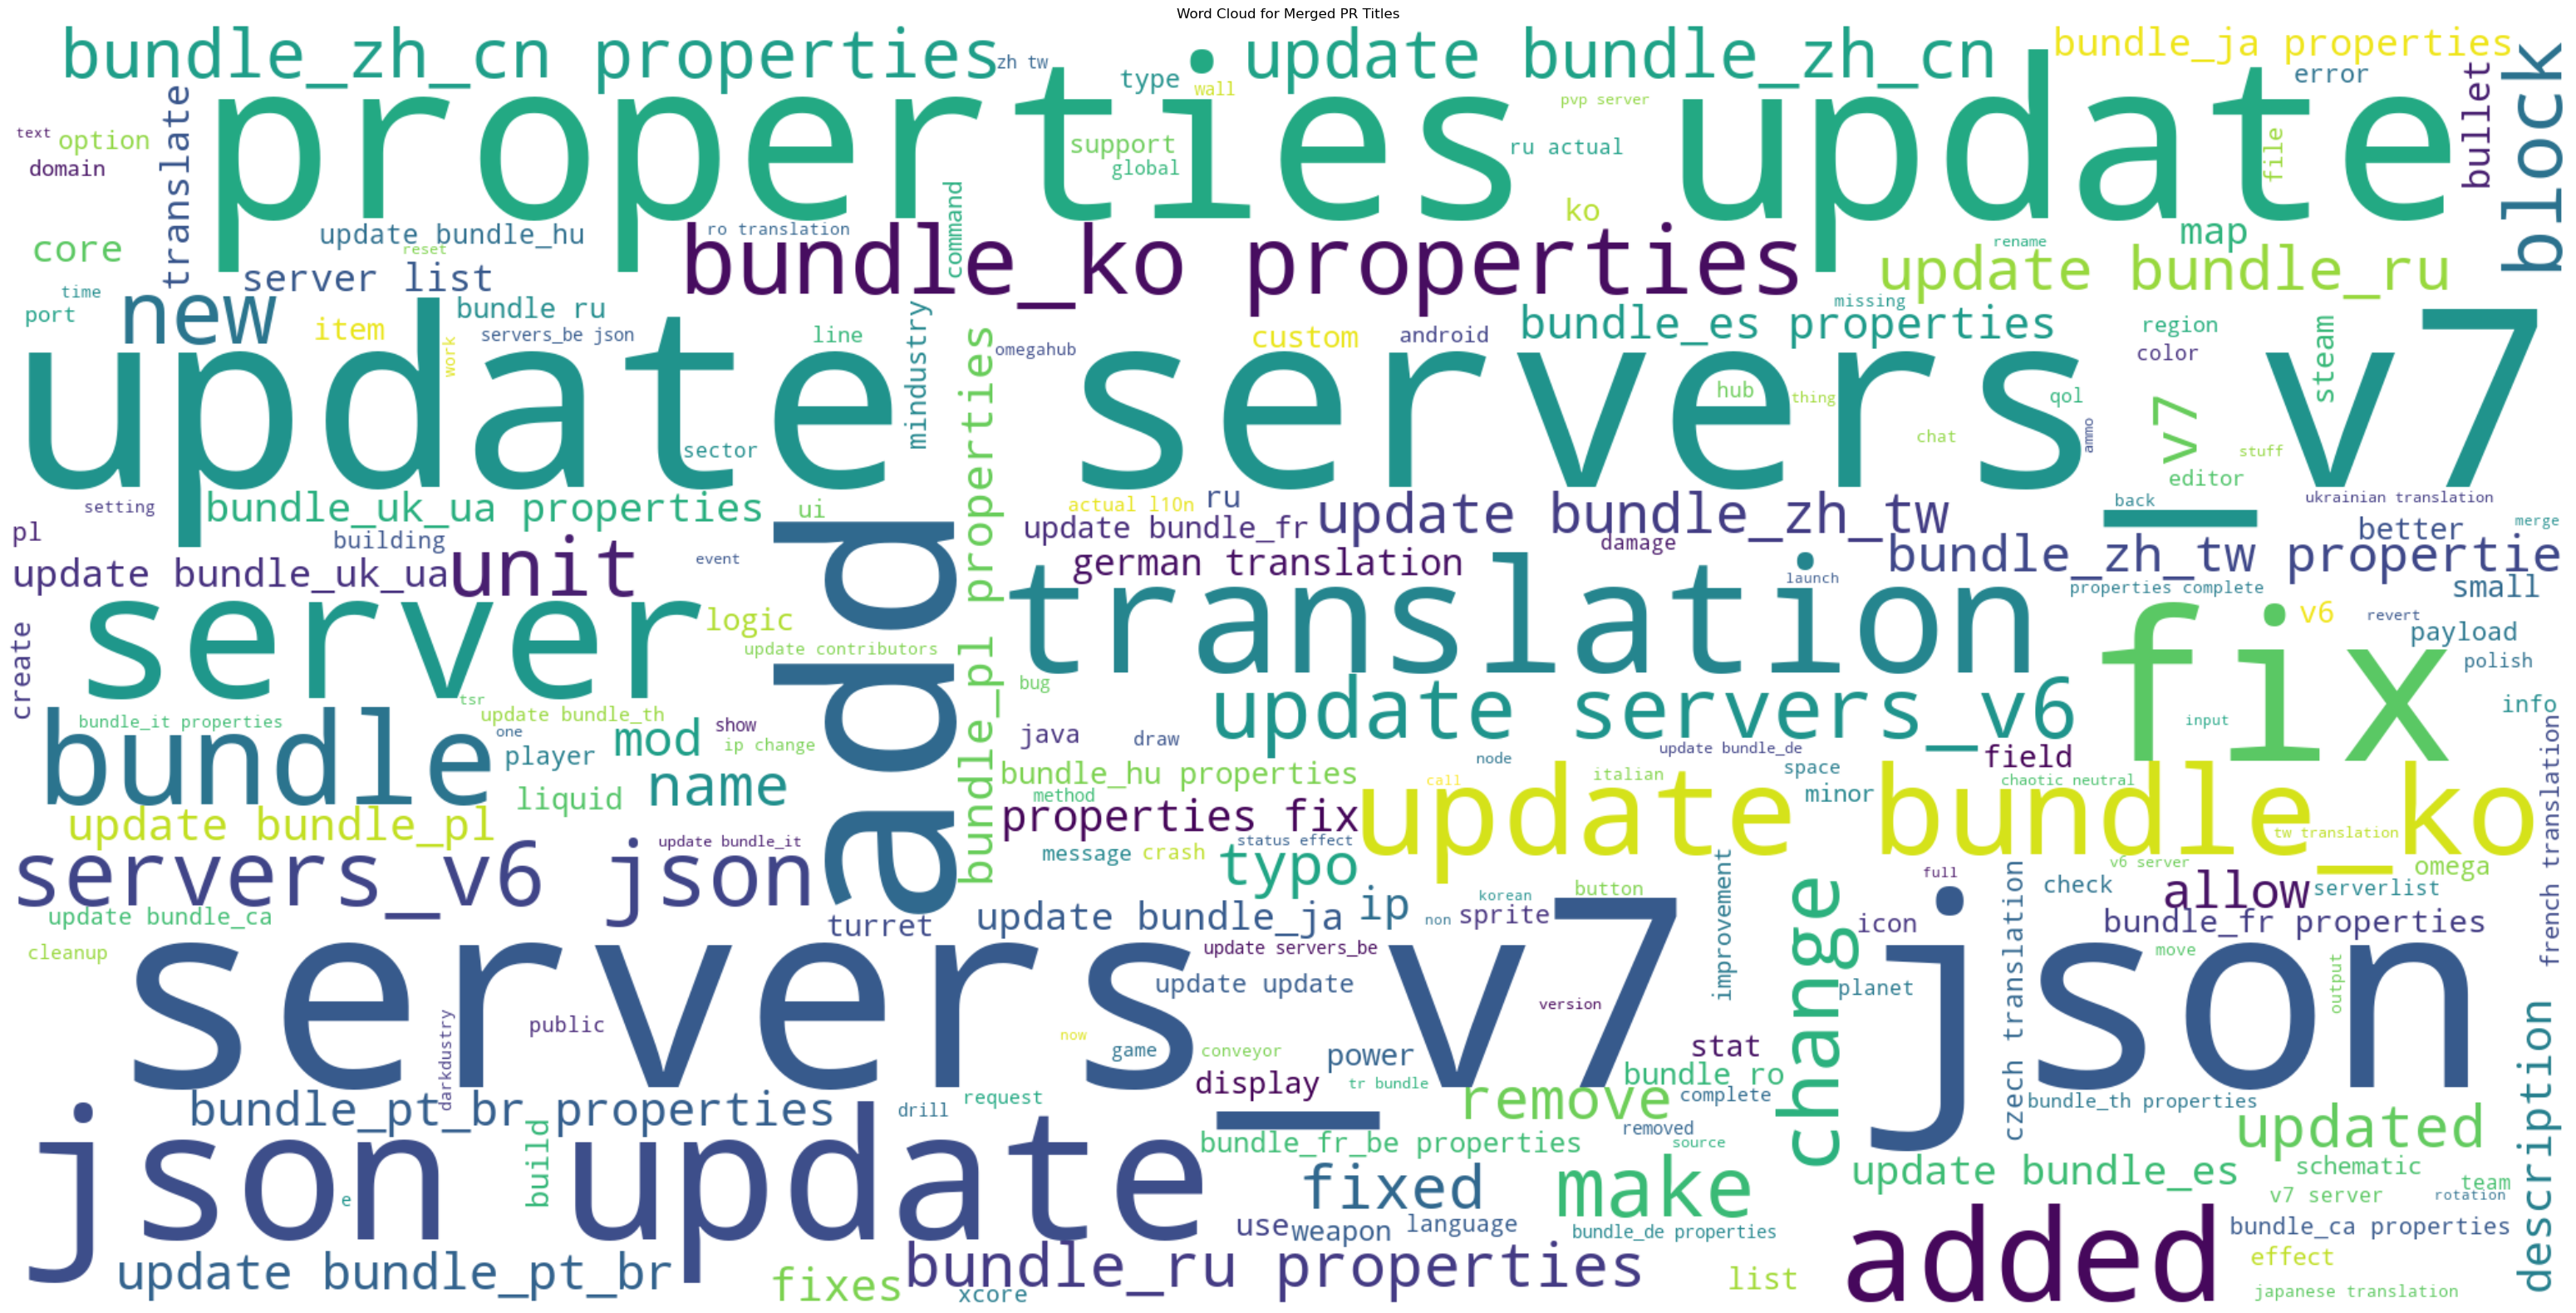

In [65]:
merged_titles = ' '.join(merged_pull_requests_df['title'].dropna().str.lower())

# Tạo word cloud cho merged PRs titles
merged_wordcloud = WordCloud(width=2000, height=1000, background_color='white', colormap='viridis').generate(merged_titles)

# Hiển thị word cloud cho merged PRs titles
plt.figure(figsize=(40, 20))
plt.imshow(merged_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Merged PR Titles')
plt.axis('off')
plt.show()


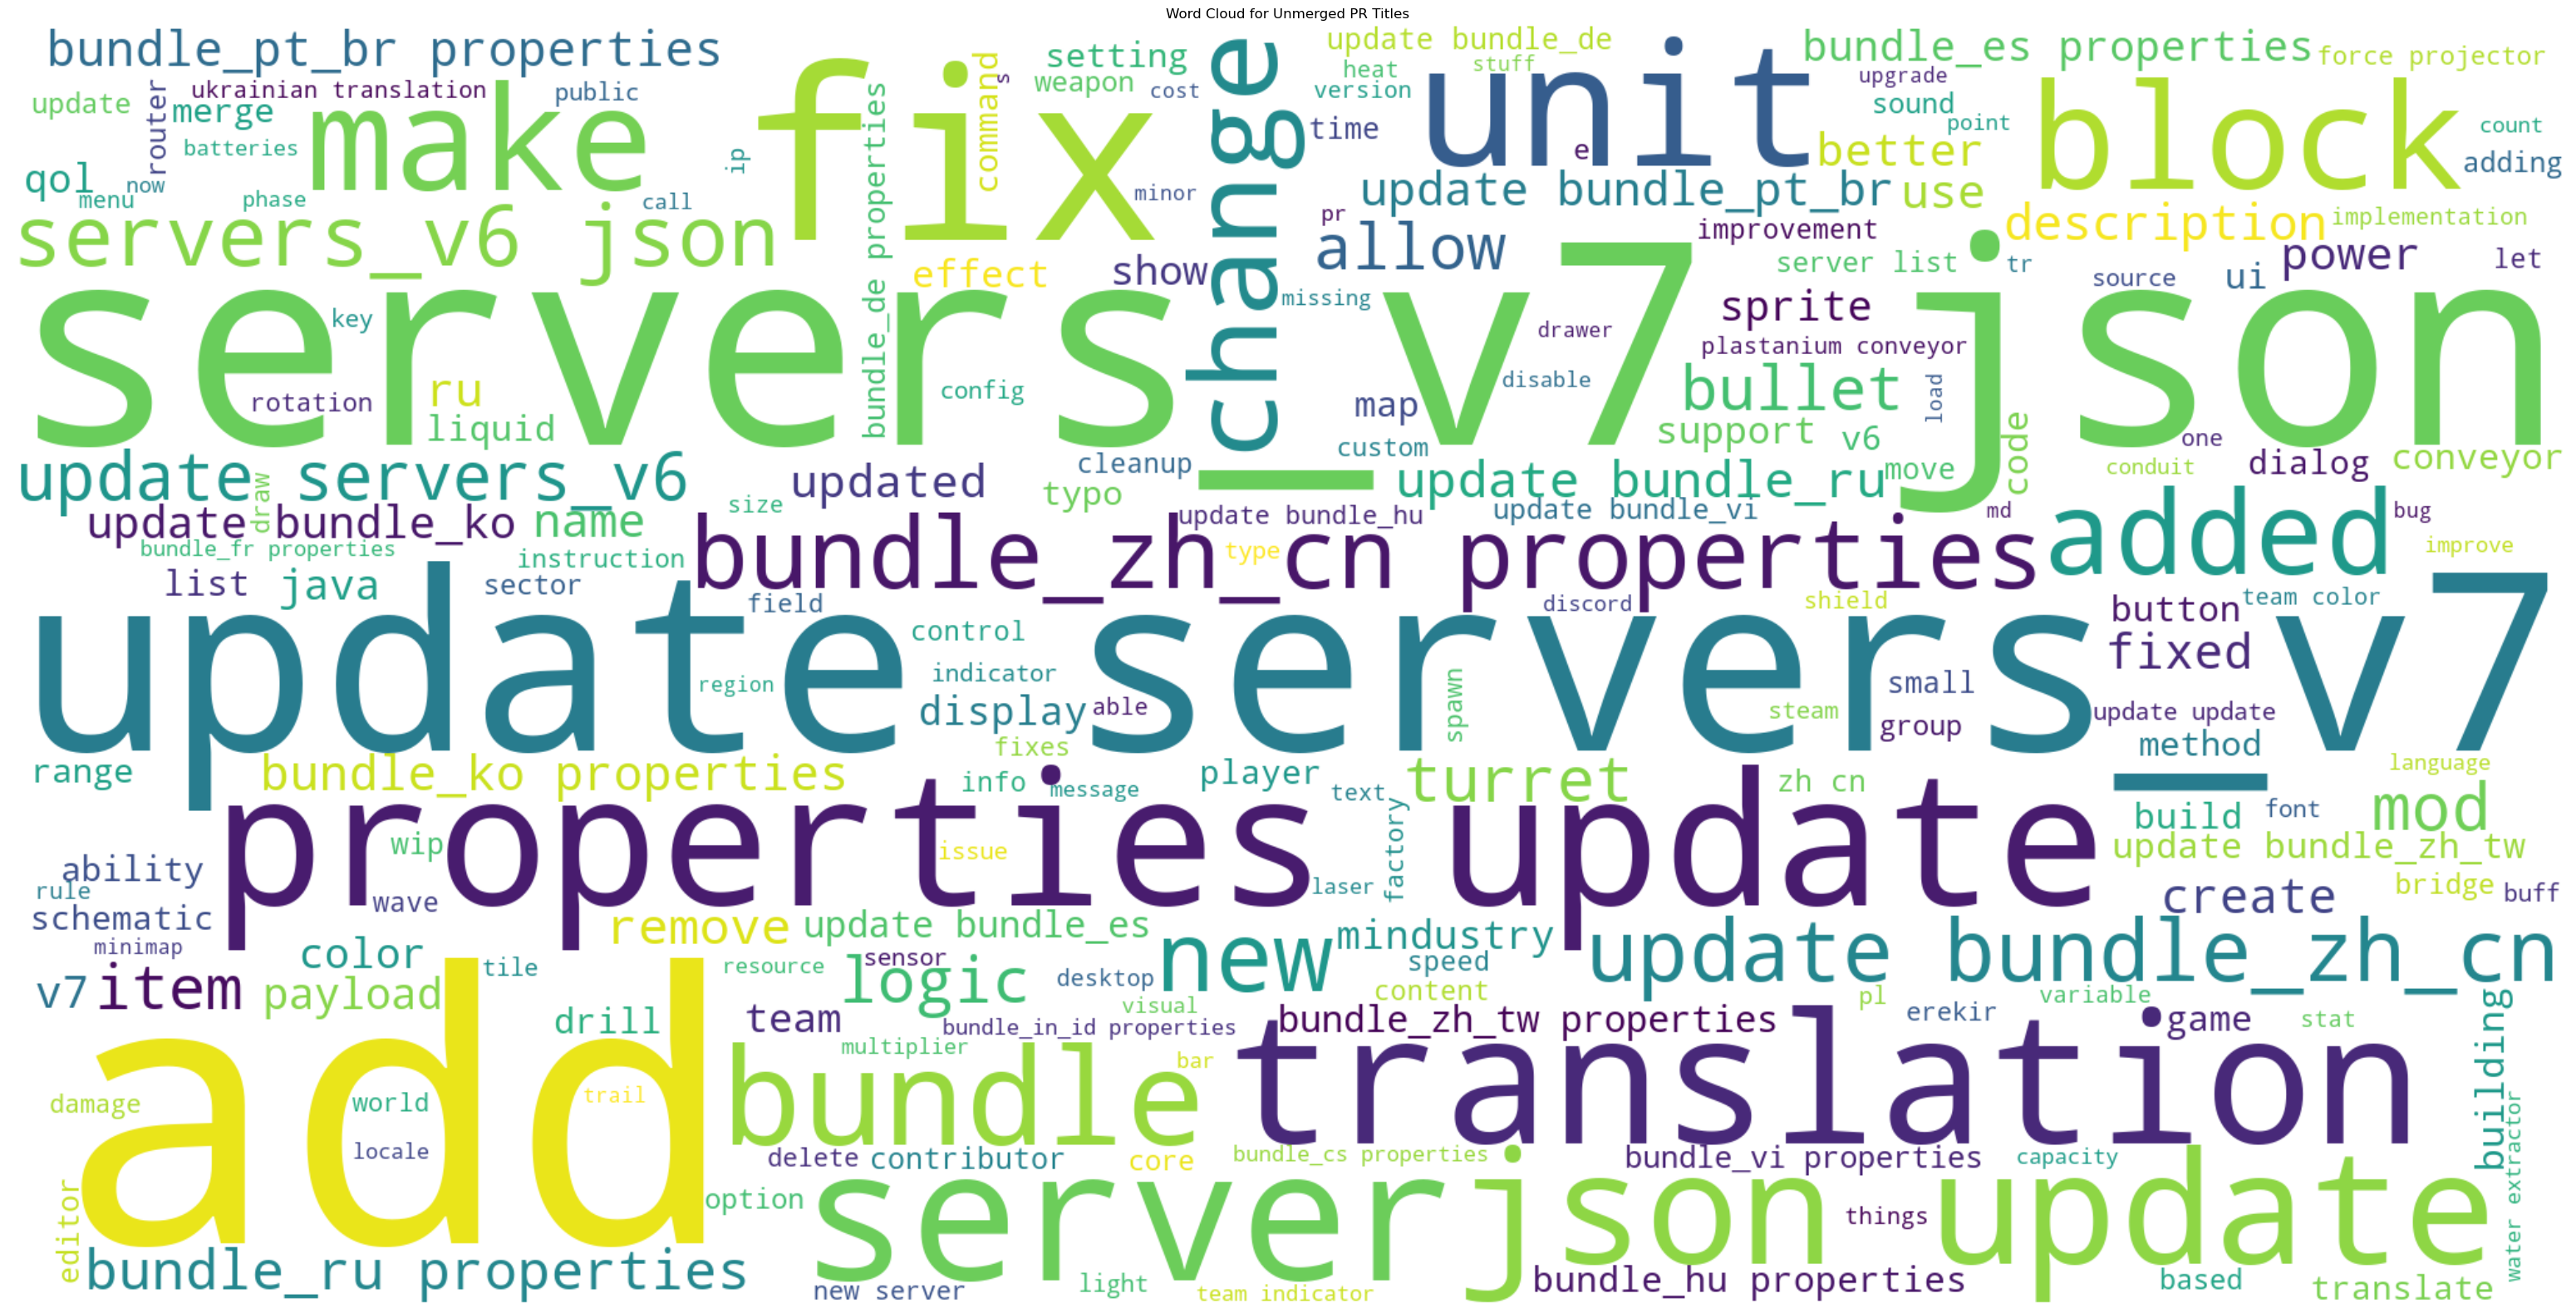

In [66]:
unmerged_pull_requests_df = pull_requests_df[pull_requests_df['merged_at'].isna()]
unmerged_titles = ' '.join(unmerged_pull_requests_df['title'].dropna().str.lower())

# Tạo word cloud cho unmerged PRs titles
unmerged_wordcloud = WordCloud(width=2000, height=1000, background_color='white', colormap='viridis').generate(unmerged_titles)

# Hiển thị word cloud cho unmerged PRs titles
plt.figure(figsize=(40, 20))
plt.imshow(unmerged_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Unmerged PR Titles')
plt.axis('off')
plt.show()

ANALYSIS OF PROGRAMMING LANGUAGES

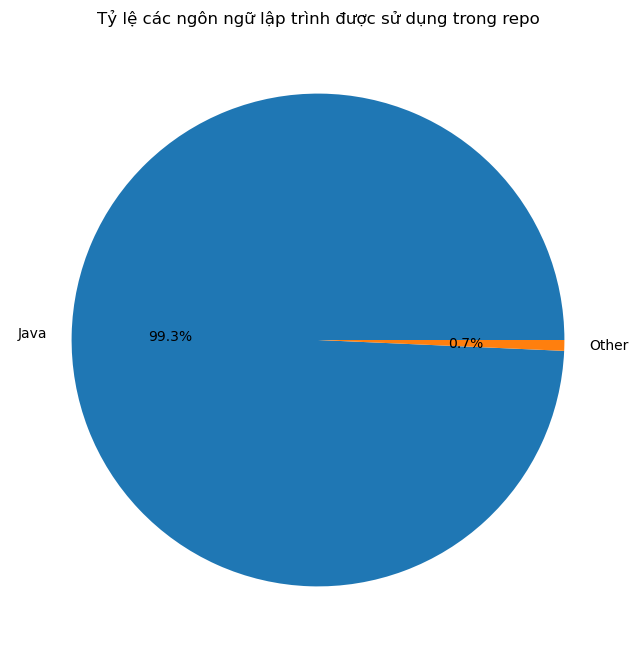

In [68]:
# Vẽ biểu đồ quạt thể hiện tỷ lệ các ngôn ngữ lập trình
languages_df.set_index('language', inplace=True)
languages_df.plot.pie(y='lines', autopct='%1.1f%%', figsize=(8, 8), legend=False)
plt.title('Tỷ lệ các ngôn ngữ lập trình được sử dụng trong repo')
plt.ylabel('')
plt.show()


ANALYSIS OF FILES

In [ ]:
# Chung
average_file_size = files_df['size'].mean()
print(f'Kích thước trung bình của các files: {average_file_size:.2f} bytes')

Kích thước trung bình của các files: 16681.07 bytes


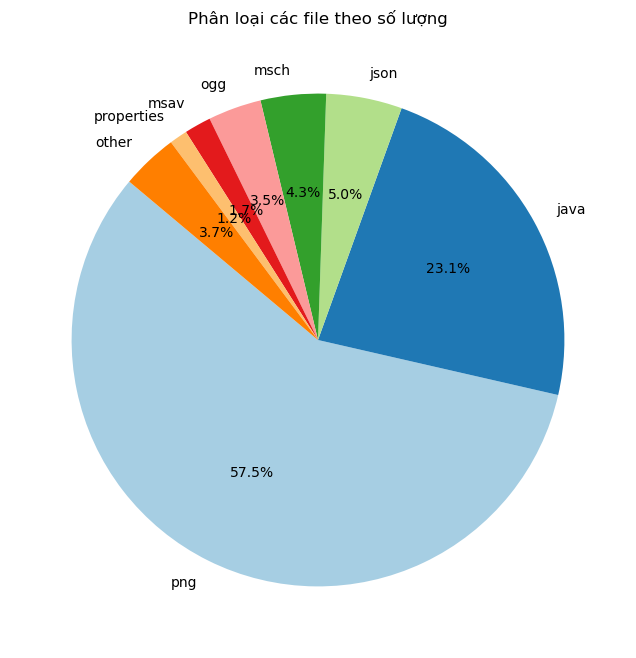

In [ ]:
# Phân tích files theo loại (extension)

file_extension_counts = files_df['extension'].value_counts()
count_threshold = 0.01 * files_df.shape[0]
file_extension_counts_revised = file_extension_counts.copy()
file_extension_counts_revised[file_extension_counts < count_threshold] = 0
file_extension_counts_revised['other'] = file_extension_counts[file_extension_counts < count_threshold].sum()
file_extension_counts_revised = file_extension_counts_revised[file_extension_counts_revised > 0]

# Vẽ biểu đồ quạt theo số lượng files
plt.figure(figsize=(10, 8))
plt.pie(file_extension_counts_revised, labels=file_extension_counts_revised.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Phân loại các file theo số lượng')
plt.show()

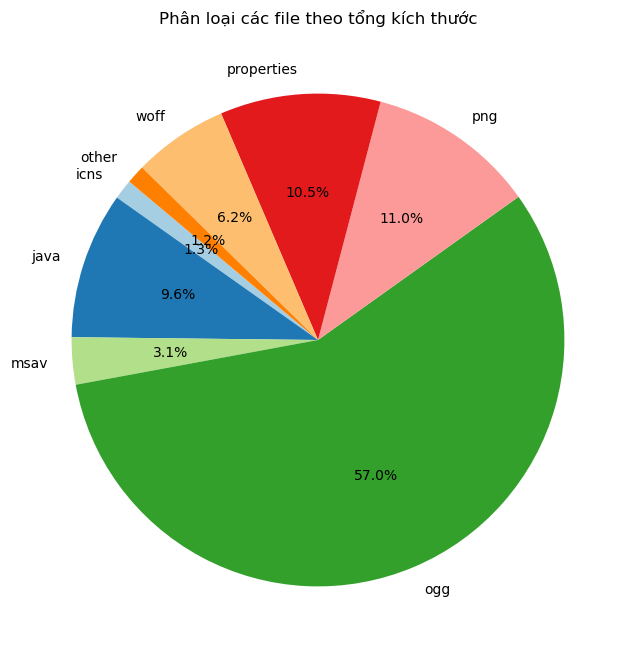

In [ ]:
file_extension_sizes = files_df.groupby('extension')['size'].sum()
size_threshold = 0.01 * file_extension_sizes.sum()

file_extension_sizes_revised = file_extension_sizes.copy()
file_extension_sizes_revised[file_extension_sizes < size_threshold] = 0
file_extension_sizes_revised['other'] = file_extension_sizes[file_extension_sizes < size_threshold].sum()
file_extension_sizes_revised = file_extension_sizes_revised[file_extension_sizes_revised > 0]

# Vẽ biểu đồ quạt theo tổng kích thước files
plt.figure(figsize=(10, 8))
plt.pie(file_extension_sizes_revised, labels=file_extension_sizes_revised.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Phân loại các file theo tổng kích thước')
plt.show()

ANALYSIS OF README

In [ ]:
# nothing here

ANALYSIS OF GROWTH

In [ ]:
commits_df['month'] = commits_df['date'].dt.to_period('M')

# Tính tổng số commits trong từng tháng của năm 2023
commits_per_month = commits_df.groupby('month').size()

# Tính tổng số contributors trong từng tháng của năm 2023
contributors_per_month = commits_df.groupby('month')['author'].nunique()

# Kết hợp dữ liệu commits và contributors
data = pd.DataFrame({
    'Total Commits': commits_per_month.cumsum(),
    'Total Contributors': contributors_per_month.cumsum()
})

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12248\3496850139.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  commits_df['month'] = commits_df['date'].dt.to_period('M')


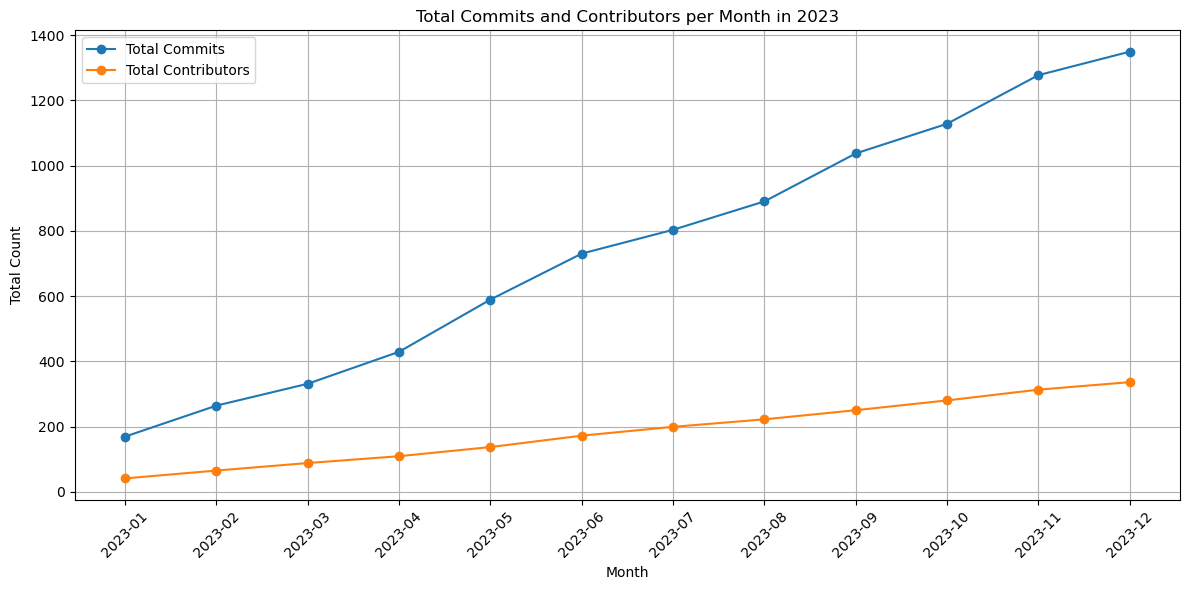

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index.astype(str), data['Total Commits'], marker='o', label='Total Commits')
plt.plot(data.index.astype(str), data['Total Contributors'], marker='o', label='Total Contributors')

plt.title('Total Commits and Contributors per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Total Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()